# Asset Pricing Homework 4

*By Daniel Deutsch, José Lucas Barretto and Ziyad Bekkaoui*.

In [1]:
import warnings
from datetime import date

import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from nelson_siegel_svensson import NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
from scipy.interpolate import CubicSpline
from sklearn.decomposition import PCA

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Load Data

Firstly, we needed to obtain our data. We did it by accessing the [treasury website](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldYear&year=2021) and selecting the daily treasury yield curve rates of 10/01/21. The data itself consist on yields projections on different maturities (1M, 2M, 3M, 6M, 1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y).

In [3]:
df_full = pd.read_csv("./datasets/daily_treasury_yield_curve_rates.csv")
df_full

,date,1M,2M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
0,01/04/21,0.09,0.09,0.09,0.09,0.10,0.11,0.16,0.36,0.64,0.93,1.46,1.66
1,01/05/21,0.08,0.09,0.09,0.09,0.10,0.13,0.17,0.38,0.66,0.96,1.49,1.70
2,01/06/21,0.09,0.09,0.09,0.09,0.11,0.14,0.20,0.43,0.74,1.04,1.60,1.81
3,01/07/21,0.09,0.09,0.09,0.09,0.11,0.14,0.22,0.46,0.78,1.08,1.64,1.85
4,01/08/21,0.08,0.08,0.08,0.09,0.10,0.14,0.24,0.49,0.81,1.13,1.67,1.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,10/25/21,0.07,0.10,0.06,0.06,0.14,0.47,0.76,1.19,1.47,1.64,2.07,2.09
205,10/26/21,0.06,0.08,0.06,0.06,0.14,0.47,0.77,1.20,1.46,1.63,2.03,2.05
206,10/27/21,0.06,0.07,0.06,0.07,0.12,0.50,0.77,1.16,1.41,1.54,1.93,1.95
207,10/28/21,0.06,0.10,0.06,0.06,0.15,0.50,0.77,1.18,1.44,1.57,1.98,1.96


# Yield Curve Interpolation

## Selects Day

For the yield curve interpolation analysis we decided to work with the data from the day 10/01/2021.

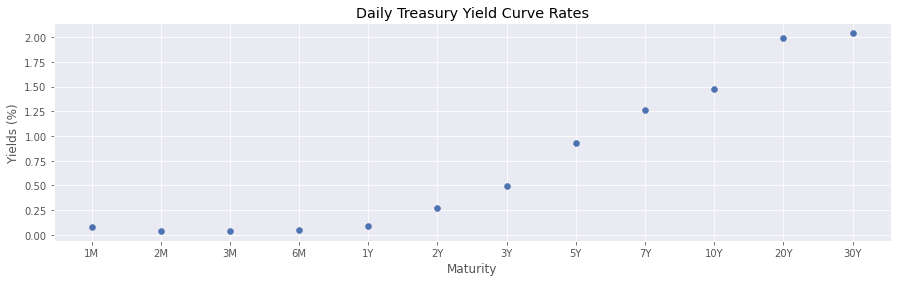

In [4]:
# Select 
df = pd.read_csv("./datasets/daily_treasury_yield_curve_rates.csv")
df = df[df['date'] == '10/01/21']
df = df.transpose().iloc[1:].reset_index()
df.rename(columns={'index': 'maturity', 189: 'yield'}, inplace=True)
df['yield'] = df['yield'].astype('float')

# Plot
plt.scatter(df['maturity'], df['yield'])
plt.title("Daily Treasury Yield Curve Rates")
plt.xlabel("Maturity")
plt.ylabel("Yields (%)")
plt.show()

## Adjust Scale

From the plot above we can see that the scale in the x axis ins't right. We, then, fix it.

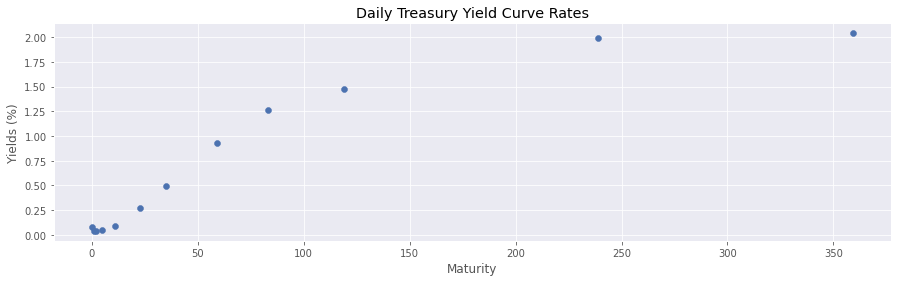

In [5]:
# Defines constants
START_DATE = date.fromisoformat('2021-10-01')

# Obtains the dates
dates = []
for maturity in df['maturity']:
    if maturity[-1] == 'M':
        date = START_DATE + relativedelta(months=int(maturity[:-1]))
    elif maturity[-1] == 'Y':
        date = START_DATE + relativedelta(years=int(maturity[:-1]))
    dates.append(date.isoformat())

# Replaces the maturity into dates in the dataframe
df['maturity'] = pd.to_datetime(dates)

# Creates an array with monthly frequency between the maturity min and max dates
dates = pd.date_range(df['maturity'].min(), df['maturity'].max(), freq='M').to_series('maturity').astype('datetime64[M]')
dates = dates.append(pd.Series([df['maturity'].max()], name='maturity'))
dates = dates.rename('maturity')

# Merge
df = df.merge(dates, on='maturity', how='right')
df['maturity'] = df.index
df.dropna(inplace=True)

# Plot
plt.scatter(df['maturity'], df['yield'])
plt.title("Daily Treasury Yield Curve Rates")
plt.xlabel("Maturity")
plt.ylabel("Yields (%)")
plt.show()

## Cubic Splines

The cubic splines based term structure estimation method divides the term structure into segments using a series of so-called knot points. Cubic polynomial functions are then used to fit the term structure over these segments. The polynomial functions ensure the continuity and smoothness of the discount function within each interval. McCulloch (1971, 1975) use the following definition of the discount factors:

\begin{align*}
    \delta (m_{ij}, \beta) \quad & = \quad 1 + \sum_{l=1}^{n} \beta^l g^l(m_{ij})
\end{align*}

Where $g^l(mij)$ $(l=1, ..., n)$ defines a set of piecewise cubic functions, the so-called basis functions, which satisfy $g^l(0) = 0$. The functions have to be twice-differentiable at each knot point to ensure a smooth and continuous curve around the points.

In the Following piece of code we fit a cubic splines model in the Yields of 10/01/2021.

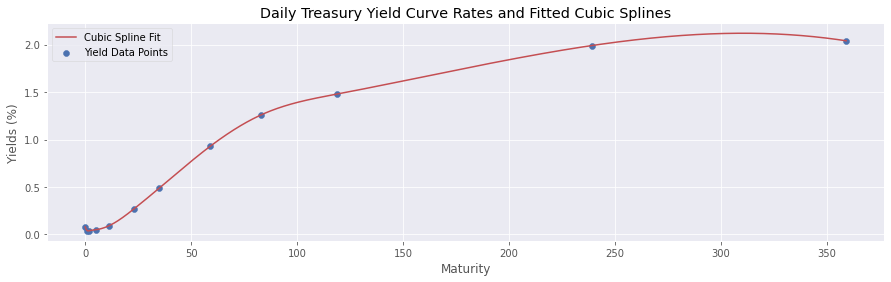

In [6]:
# Builds the cubic splines model over the data
model = CubicSpline(df['maturity'], df['yield'])

# Gets curve points
t = np.linspace(df['maturity'].min(), df['maturity'].max(), 1000)

# Plot model results
plt.scatter(df['maturity'], df['yield'], label='Yield Data Points')
plt.plot(t, model(t), label='Cubic Spline Fit', c='#C44E52')
plt.title("Daily Treasury Yield Curve Rates and Fitted Cubic Splines")
plt.xlabel("Maturity")
plt.ylabel("Yields (%)")
plt.legend()
plt.show()


## Nelson-Siegel

The Nelson–Siegel forward rate curve can be viewed as a constant plus a Laguerre function, which is a polynomial times an exponential decay term and is a popular mathematical approximating function. The corresponding yield curve is:

\begin{align*}
    y_t(\tau) \quad &= \quad \beta_{0t} + \beta_{1t} \frac{1-e^{-\lambda \tau}}{\lambda \tau} + \beta_{2t} \left( \frac{1-e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau} \right)
\end{align*}

The Nelson–Siegel yield curve also corresponds to a discount curve that begins at one at zero maturity and approaches zero at infinite maturity, as appropriate.

- The parameter $\lambda_{\tau}$ governs the exponential decay rate; small values of $\lambda_{\tau}$ produce slow decay and can better fit the curve at long maturities, while large values of $\lambda_{\tau}$ produce fast decay and can better fit the curve at short maturities. $\lambda_{\tau}$ also governs where the loading on $\beta_{2t}$ achieves its maximum.
- We interpret $\beta_{0t}$, $\beta_{1t}$ and $\beta_{2t}$ as three latent dynamic factors. The loading on $\beta_{0t}$ is 1, a constant that does not decay to zero in the limit; hence it may be viewed as a long-term factor. The loading on $\beta_{1t}$ is $\frac{1-e^{-\lambda \tau}}{\lambda \tau}$, a function that starts at 1 but decays monotonically and quickly to 0; hence it may be viewed as a short-term factor. The loading on $\beta_{2t}$ is $\left( \frac{1-e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau} \right)$, which starts at 0 (and is thus not short-term), increases, and then decays to zero (and thus is not long-term); hence it may be viewed as a medium-term factor.

Thus, in the code below, we Obtain the parameters of the Nelson-Siegel model and, with these parameters, estimate the zero rates of the curve given $t$.

NelsonSiegelCurve(beta0=2.3354691107512675, beta1=-2.274559549032985, beta2=-2.5974960270861516, tau=19.698898196741517)



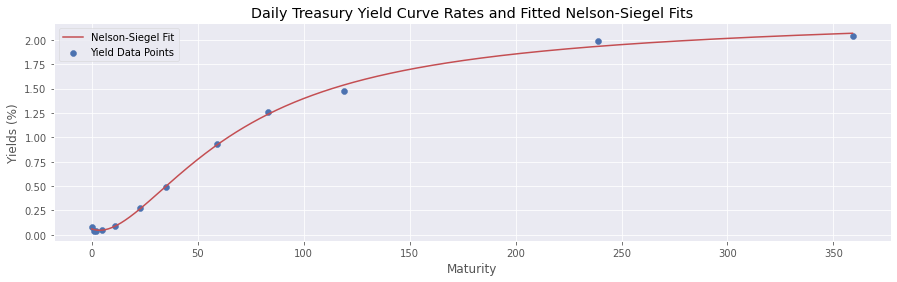

In [7]:
# Obtains the parameters of the model
model_fit, status = calibrate_ns_ols(df['maturity'].to_numpy(), df['yield'].to_numpy())
print(model_fit, end='\n\n')

# Obtains the zero rates of the curve given time t
zero_rates = NelsonSiegelCurve.zero(model_fit, t)

# Plot model results
plt.scatter(df['maturity'], df['yield'], label='Yield Data Points')
plt.plot(t, zero_rates, label='Nelson-Siegel Fit', c='#C44E52')
plt.title("Daily Treasury Yield Curve Rates and Fitted Nelson-Siegel Fits")
plt.xlabel("Maturity")
plt.ylabel("Yields (%)")
plt.legend()
plt.show()

# Yield Curve Factorial Analysis

In the following piece of code we perform a PCA (Principal Component Analysis) in the full dataframe (the one containing yields from various dates) and plot the four most influential components. Notice that here, we are working on the differences between each date.

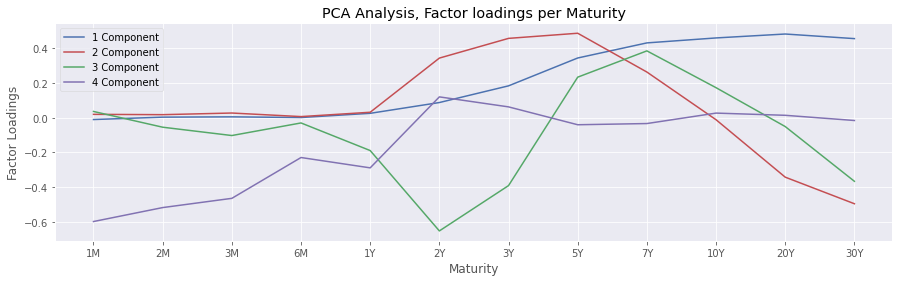

In [8]:
# Obtains the yields differences matrix for all the dates
X = df_full.iloc[:, 1:].diff().dropna().to_numpy()

# Gets 3 principal components
model = PCA()
model_fit = model.fit(X)

# Plot components
for i, component in enumerate(model_fit.components_[:4]):
    plt.plot(df_full.columns[1:], component, label=f"{i+1} Component")
plt.title("PCA Analysis, Factor loadings per Maturity")
plt.xlabel("Maturity")
plt.ylabel("Factor Loadings")
plt.legend()
plt.show()
